In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
from joblib import Parallel, delayed

# lines 6 - 29 from: https://www.danli.org/2021/02/03/single-cell-data-analysis-using-scanpy/ 
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

adata = sc.read_10x_mtx(
    "datasets", 
    var_names="gene_symbols",
    cache=True
)

adata.var_names_make_unique()

#filter 20 highest expressed genes
#sc.pl.highest_expr_genes(adata, n_top=20, )

#filtering out the cells with low gene expression/genes that don't show up in many cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata_filter1 = adata.copy()
adata_filter1.write('adata_first_filter.h5ad')

#annotate mitochondrial genes as 'mt' and calculate qc metrics based on 
adata_filter1.var['mt'] = adata_filter1.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata_filter1.var['ribo'] = adata_filter1.var_names.str.startswith(("RPS", "RPL"))
adata_filter1.var['hb'] = adata_filter1.var_names.str.startswith("^HB[^(P)]") #regular expression that chooses all leters after HB besides the capital letter P
#regex is used because pseudogenes have names like HBP1, HBP2, etc 

sc.pp.calculate_qc_metrics(adata_filter1, qc_vars=["mt", "ribo", "hb"], percent_top=None, log1p=False, inplace=True)

/Users/anushkadole/scRNA-pancreatic/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.3 anndata==0.10.9 umap==0.5.9.post2 numpy==2.0.2 scipy==1.13.1 pandas==2.3.1 scikit-learn==1.6.1 statsmodels==0.14.5 igraph==0.11.9 pynndescent==0.5.13
... reading from cache file cache/datasets-matrix.h5ad
filtered out 1478 genes that are detected in less than 3 cells


In [ ]:
#SKIP
sc.pl.violin(adata_filter1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata_filter1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.scatter(adata_filter1, 'total_counts', 'pct_counts_mt')

In [2]:
adata_cp1 = adata_filter1[
    (adata_filter1.obs['pct_counts_mt'] < 10) &
    (adata_filter1.obs['pct_counts_ribo'] < 20) &
    (adata_filter1.obs['pct_counts_hb'] < 5),
    :
].copy()

In [ ]:
#SKIP
sc.pl.violin(adata_cp1, ['pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, multi_panel=True)

In [ ]:
adata_cp2 = adata_cp1.copy()
adata_cp2.obs["doublet_score"] = np.nan
adata_cp2.obs["predicted_doublet"] = np.nan

sample_indices = np.arange(adata_cp1.n_obs)

chunk_size = 20000
num_chunks = adata_cp2.shape[0] // chunk_size
try:
    for i in range(num_chunks+1):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, adata_cp2.shape[0])
        adata_subset = adata_cp2[start:end].copy()
        sc.pp.scrublet(adata_subset)
        adata_cp2.obs.loc[adata_subset.obs.index, "doublet_score"] = adata_subset.obs["doublet_score"]
        adata_cp2.obs.loc[adata_subset.obs.index, "predicted_doublet"] = adata_subset.obs["predicted_doublet"]
        print(f"Scrublet round {i} complete")
        
except MemoryError as e:
    print(f"Not enough memory")
    sys.exit(1)

Running Scrublet
filtered out 7532 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 22.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%
    Scrublet finished (0:01:10)
Scrublet round 0 complete


/var/folders/lq/975sjw597cx0pdrngj4hf1tr0000gn/T/ipykernel_24894/2921145158.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_cp2.obs.loc[adata_subset.obs.index, "predicted_doublet"] = adata_subset.obs["predicted_doublet"]


Running Scrublet
filtered out 6186 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 13.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%
    Scrublet finished (0:01:05)
Scrublet round 1 complete
Running Scrublet
filtered out 6078 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'hi

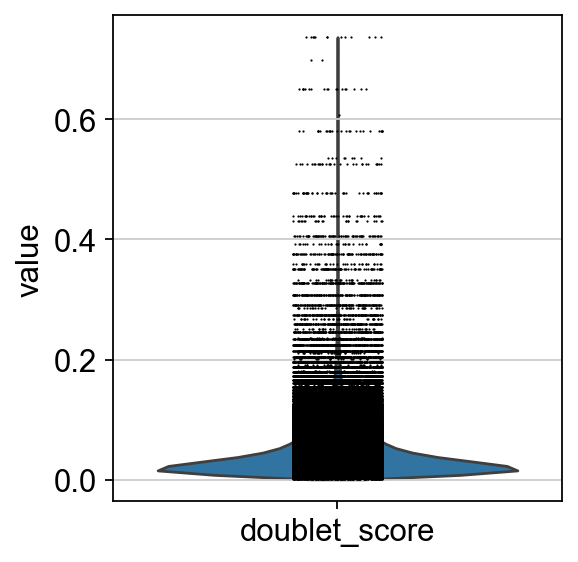

In [7]:
adata_cp3 = adata_cp2.copy()
sc.pl.violin(adata_cp2, 'doublet_score')

In [11]:
threshold = 0.18
adata_singlets = adata_cp3[adata_cp3.obs['doublet_score'] < threshold, :].copy()

In [13]:
# Saving count data
adata_singlets.layers["counts"] = adata_singlets.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata_singlets)
# Logarithmize the data
sc.pp.log1p(adata_singlets)

normalizing counts per cell
    finished (0:00:02)
